In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import time
import glob
import os
from tqdm import tqdm

In [26]:
#parameters
chan_min = 1600
chan_max = 1700
channel_number = chan_max -chan_min
low_cut1 = 1
hi_cut1 = 10
fs = 100
samples_per_file = 60*fs
b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)

In [3]:
file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-13*")
file_list

['/data/data5/Converted/whidbey_2022-05-17_08-13-00_UTC_014628.h5']

# Buiding Template

In [27]:
#first version, just one event
#download template oso earthquake data

# Ruta del archivo HDF5
rawdata_path = '/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5'

# Abrir el archivo HDF5
with h5py.File(rawdata_path, 'r') as rawdata_file:
    # Acceder a los datos que deseas
    rawdata = rawdata_file['Acquisition/Raw[0]/RawData']

    # Lee los datos en un arreglo NumPy
    this_template = np.array(rawdata[:, chan_min:chan_max])
    rawdata_file.close()
# Ahora puedes continuar con el procesamiento de los datos
b, a = butter(2, (low_cut1, hi_cut1), 'bp', fs=fs)
template_filt = filtfilt(b, a, this_template, axis=0)
template = template_filt[5000:5500,:]

# Recuerda cerrar el archivo HDF5 cuando hayas terminado si es necesario


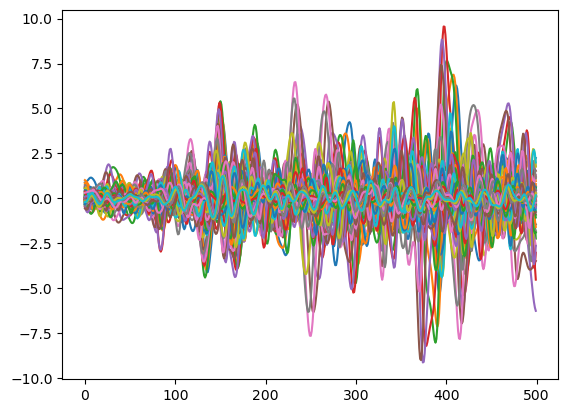

In [28]:
plt.plot(template)
plt.show()


In [ ]:
#Second version making a nicer template


#file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-07*")
#file_list
#download template oso earthquake data
#template_file1 = h5py.File('/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5','r') #originaltemplate
template_file1 = '/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5'
#template_file2 = '/data/data5/Converted/whidbey_2022-05-17_08-11-00_UTC_014626.h5'
template_file3 = '/data/data5/Converted/whidbey_2022-05-17_08-13-00_UTC_014628.h5'
##
templates = []
templates_filt = []
#templates = [template_file1,template_file2,template_file3]
templates = [template_file1,template_file3]

##Opening and filtering two templates

for file in templates:
    with h5py.File(file,"r") as f:
         # read the data and extract timing information
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
        #timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
        data_filt = filtfilt(b,a,raw_data,axis=0)
        
        
        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
    templates_filt.append(data_filt)
    f.close()
    
#this_template = np.array(template_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
#this_time1 = np.array(template_file['Acquisition/Raw[0]/RawDataTime'])
#attrs1 =     dict(template_file['Acquisition'].attrs)
            
#template_file.close()



#b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
#data_filt = filtfilt(b,a,this_data,axis=0)
#template_filt = filtfilt(b,a,this_template,axis=0)

#template = template_filt[5000:5500,:]
#template.shape
#data_filt.shape


In [23]:
#Run this in any case, it's doesnt matter, functions to correlate


def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr


def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr
#corrs =  []
#corrs = (window_and_correlate(template,template_filt))

In [ ]:
#Calculating cross-correlation for both templates

cross_correlation_1_2 = correlate(templates_filt[0],templates_filt[1])
#cross_correlation_1_3 = correlate(templates_filt[0],templates_filt[2])
#cross_correlation_2_3 = correlate(templates_filt[1],templates_filt[2])

#plt.plot(cross_correlation_2_3)
#plt.show()


#Calculating time displacement
shift_1_2 = np.argmax(cross_correlation_1_2) - (len(templates_filt[0]) - 1)
#shift_1_3 = np.argmax(cross_correlation_1_3) - (len(templates_filt[1]) - 1)
#shift_2_3 = np.argmax(cross_correlation_2_3) - (len(templates_filt[2]) - 1)

#alignide them a plot it to see if it works!

aligned_data1 = np.roll(templates_filt[0], -shift_1_2)
aligned_data2 = templates_filt[1]  # No es necesario desplazar data2, ya que data1 se alineó con data2
#aligned_data3 = np.roll(templates_filt[2], -shift_2_3)

plt.figure(figsize=(10, 6))  

plt.plot(aligned_data1, label='Datos 1')
plt.plot(aligned_data2, label='Datos 2 (Alineados)')
#plt.plot(aligned_data3, label='Datos 3 (Alineados)')
plt.grid()
plt.show()

In [ ]:
#Aligned and stacking  templates


#templates_alig = [aligned_data1, aligned_data2, aligned_data3]
templates_alig = [aligned_data1, aligned_data2]

#Calculting mean
#stacked_template = np.mean(templates_alig, axis=0)

final_template = np.sum(templates_alig, axis=0)


#choosing part of the template

template = final_template[400:900,:]#we run the code with 400:900 channels
plt.plot(template)
plt.title('template to correlate with the data')
plt.grid()
plt.show()

In [ ]:
templates_final = templates_filt[400:900,:]

In [ ]:
plt.imshow(templates_filt,cmap='seismic',aspect='auto')
plt.title('template to correlate with the data')
plt.grid()
plt.show()

In [ ]:
#testing with another earthquake from oso (magnitude 1.28)
#uw61855822	2022-07-22 12:51:02.070	4 km NE of Oso, Washington	48.300333	-121.885167	5.55	1
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-22_12-51*h5")
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-23_14-58*h5")#it should not have any earthquake here
#file_list


In [ ]:
#data_file = h5py.File('/data/data5/Converted/whidbey_2022-07-23_14-58-00_UTC_013862.h5','r')
#this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
#this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
#attrs =     dict(data_file['Acquisition'].attrs)
#data_file.close()

In [ ]:

# list


#plt.imshow(corrs[10, :, :].T, cmap='gray', aspect='auto', vmin=-1.0, vmax=1.0)

# Cross-correlation-plot
#plt.colorbar()
#plt.title('Cross-correlation')
#plt.xlabel("time-#samples")
#plt.show()


In [ ]:
#corrs2 = corrs.reshape((samples_per_file,channel_number))
#plt.imshow(corrs2, aspect= 'auto')
#plt.show()
#channel_number = chan_max -chan_min

#corrs3 = np.sum(corrs2,axis=1)/channel_number
#corrs3
#plt.plot(corrs3)
#plt.show()

In [19]:
#testing 10 files
file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08*")
len(file_list)

60

In [30]:
# Registra el tiempo de inicio
inicio_tiempo = time.perf_counter()


b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
corrs3_list = []
for i, file in tqdm(enumerate(file_list)):
    with h5py.File(file,"r") as f:
         # read the data and extract timing information
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
        #timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
        data_filt = filtfilt(b,a,raw_data,axis=0)
        # check length of files
        win_start = i*samples_per_file
        win_end = (i+1)*samples_per_file
        
        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
        f.close()
        # Calculate correlations
        corrs = window_and_correlate(template, data_filt)
        corrs2 = corrs.reshape((samples_per_file, channel_number))
        corrs3 = np.sum(corrs2, axis=1) / channel_number
        corrs3_list.append(corrs3)
        
        # Save all the corrs3 arrays into separate .npy files

        
        output_folder = './npy_files_test_allchannel-1600-1710-1hr_template'    
        for i, corrs3 in enumerate(corrs3_list):
            outfile_name = os.path.join(output_folder, f'corrs3_{i}.npy')
            np.save(outfile_name, corrs3)



                            


# Registra el tiempo de finalización
fin_tiempo = time.perf_counter()

# Calcula el tiempo de ejecución
finaltime = fin_tiempo - inicio_tiempo

print(f"code took {finaltime} seconds.")

                            

60it [00:04, 12.94it/s]

code took 4.639640238136053 seconds.


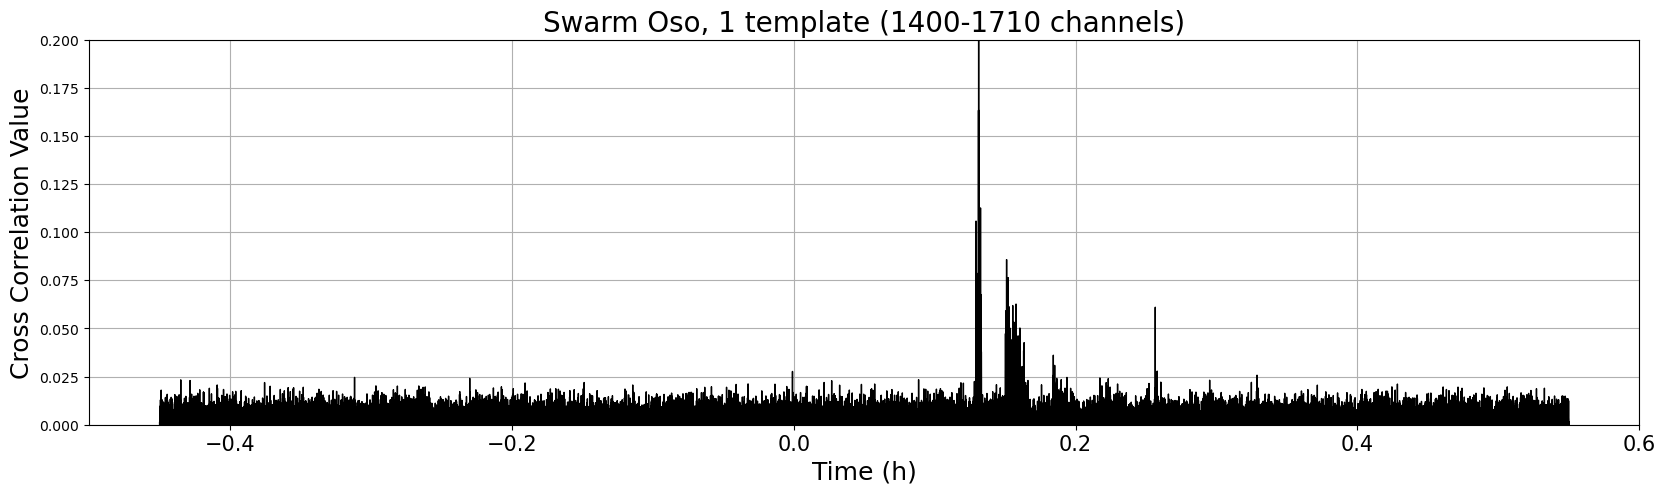

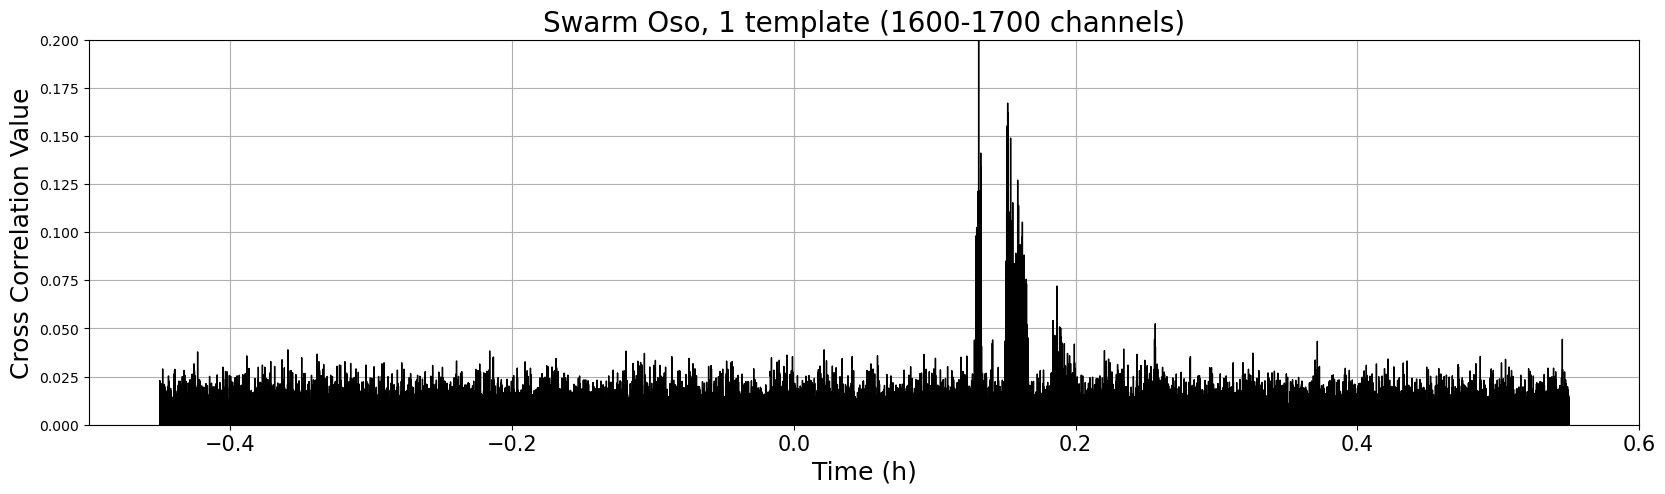

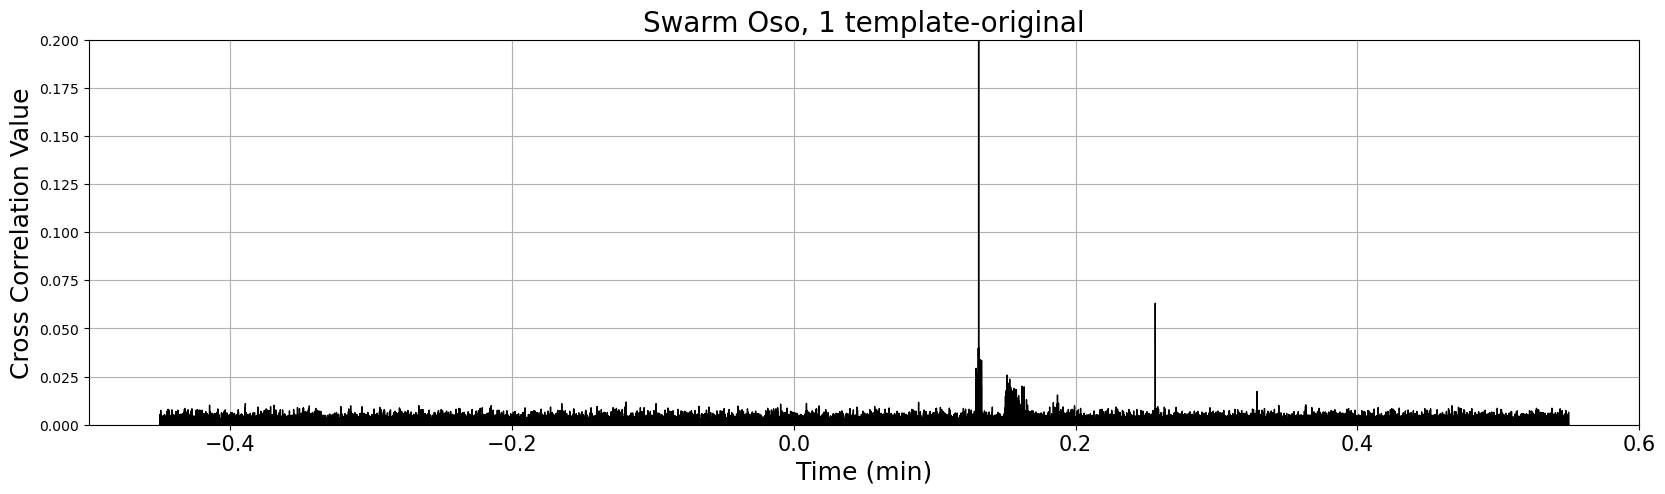

In [36]:
fig = plt.figure(figsize=(20, 5))  # Increased figure size

for i in range(len(file_list)):
    archivo_npy_a_abrir = f"./npy_files_test_allchannel-1400-1710-1hr_template/corrs3_{i}.npy"

    # load files with load
    datos = np.load(archivo_npy_a_abrir)
    t0 = i * 60
    t = np.linspace(t0, t0 + 60, 6000)

    # Plot with custom line styles and colors
    plt.plot((t / 3600)-27/60, datos, linestyle='-', color='k', linewidth=1)

plt.xlabel("Time (h)", fontsize=18)  # Increased fontsize
plt.ylabel("Cross Correlation Value", fontsize=18)  # Increased fontsize
plt.title('Swarm Oso, 1 template (1400-1710 channels)', fontsize=20)  # Increased fontsize

#plt.xlim((8.1,8.4))
#plt.xlim((8.0,8.5))
#plt.ylim((0, 0.07))
plt.ylim((0, 0.2))

plt.grid(True)
plt.tick_params(axis='x', labelsize=15)
plt.savefig('prelimfigure_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

## 

fig = plt.figure(figsize=(20, 5))  # Increased figure size

for i in range(len(file_list)):
    archivo_npy_a_abrir = f"./npy_files_test_allchannel-1600-1710-1hr_template/corrs3_{i}.npy"

    # load files with load
    datos = np.load(archivo_npy_a_abrir)
    t0 = i * 60
    t = np.linspace(t0, t0 + 60, 6000)

    # Plot with custom line styles and colors
    plt.plot((t / 3600)-27/60, datos, linestyle='-', color='k', linewidth=1)

plt.xlabel("Time (h)", fontsize=18)  # Increased fontsize
plt.ylabel("Cross Correlation Value", fontsize=18)  # Increased fontsize
plt.title('Swarm Oso, 1 template (1600-1700 channels)', fontsize=20)  # Increased fontsize

#plt.xlim((8.1,8.4))
#plt.xlim((8.0,8.5))
plt.ylim((0, 0.2))

plt.grid(True)
plt.tick_params(axis='x', labelsize=15)
plt.savefig('prelimfigure_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

##
fig = plt.figure(figsize=(20, 5))  # Increased figure size

for i in range(len(file_list)):
    archivo_npy_a_abrir = f"./npy_files_test_allchannel-0-1710/corrs3_{i}.npy"

    # load files with load
    datos = np.load(archivo_npy_a_abrir)
    t0 = i * 60
    t = np.linspace(t0, t0 + 60, 6000)

    # Plot with custom line styles and colors
    plt.plot((t / 3600)-27/60, datos, linestyle='-', color='k', linewidth=1)

plt.xlabel("Time (min)", fontsize=18)  # Increased fontsize
plt.ylabel("Cross Correlation Value", fontsize=18)  # Increased fontsize
plt.title('Swarm Oso, 1 template-original', fontsize=20)  # Increased fontsize

#plt.xlim((510,540))
plt.ylim((0, 0.2))

plt.grid(True)
plt.tick_params(axis='x', labelsize=15)
plt.savefig('prelimfigure2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#3 templates in one, screen to run stuff

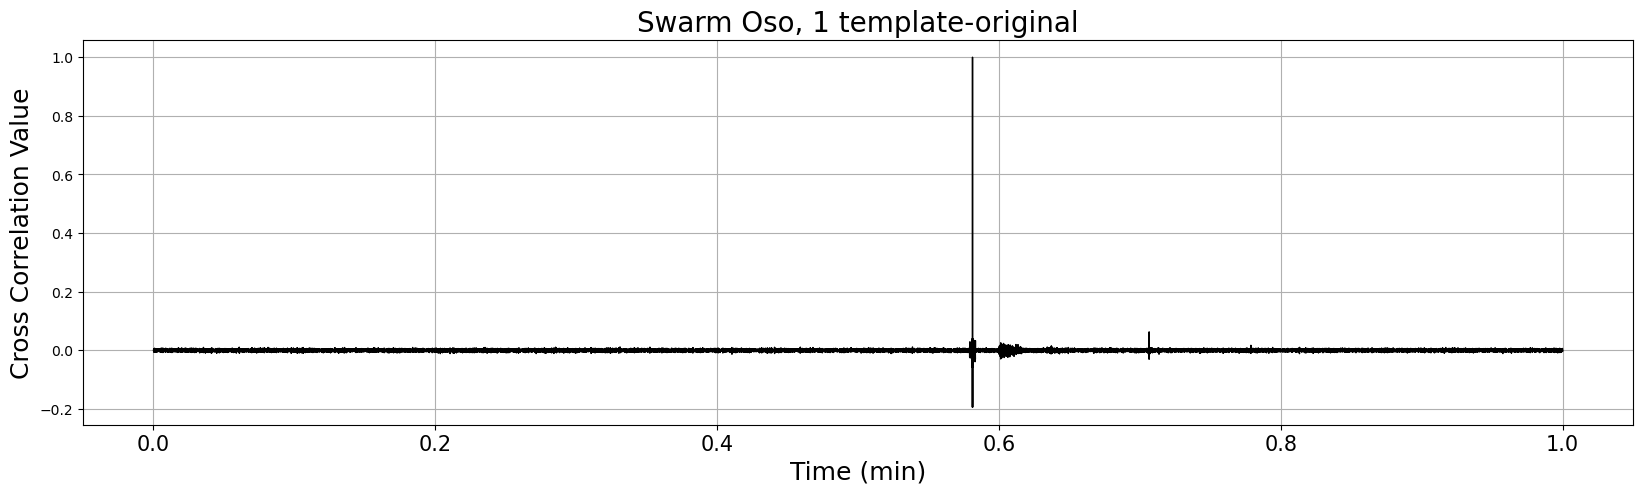